In [1]:

from google.colab import files
import zipfile, os

print("📂 Upload your EuroSAT_RGB.zip file...")
uploaded = files.upload()

zip_path = '/content/EuroSAT_RGB.zip'
extract_dir = '/content/eurosat_raw'
processed_dir = '/content/eurosat_processed'
outputs_dir = '/content/eurosat_outputs'

os.makedirs(extract_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)
os.makedirs(outputs_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ Dataset extracted to:", extract_dir)


📂 Upload your EuroSAT_RGB.zip file...


Saving EuroSAT_RGB.zip to EuroSAT_RGB.zip
✅ Dataset extracted to: /content/eurosat_raw


In [7]:
MODE = "quick"    # "quick" or "full"
ZIP_PATH = "/content/EuroSAT_RGB.zip"    # Upload here in Colab
EXTRACT_DIR = "/content/eurosat_raw"
TARGET_SIZE = (64,64)   # or (128,128)
RANDOM_SEED = 42

if MODE=="quick":
    LIMIT_PER_CLASS = 500
    EPOCHS = 12
    BATCH_SIZE = 64
else:
    LIMIT_PER_CLASS = None
    EPOCHS = 50
    BATCH_SIZE = 64

import os, random, zipfile
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


In [8]:
# ===============================
# STEP 1 — UNZIP DATASET
# ===============================
os.makedirs(EXTRACT_DIR, exist_ok=True)
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_DIR)

# Detect main folder (some zips have nested folder)
all_dirs = [d for d in Path(EXTRACT_DIR).glob("*") if d.is_dir()]
if len(all_dirs)==1:
    DATASET_DIR = all_dirs[0]
else:
    DATASET_DIR = Path(EXTRACT_DIR)

print("Dataset root:", DATASET_DIR)



Dataset root: /content/eurosat_raw/EuroSAT_RGB


In [9]:
# Detect main folder (some zips have nested folder)
all_dirs = [d for d in Path(EXTRACT_DIR).glob("*") if d.is_dir()]
if len(all_dirs)==1:
    DATASET_DIR = all_dirs[0]
else:
    DATASET_DIR = Path(EXTRACT_DIR)

print("Dataset root:", DATASET_DIR)


Dataset root: /content/eurosat_raw/EuroSAT_RGB


In [10]:
# ===============================
# STEP 2 — LOAD & PREPROCESS
# ===============================
all_images = []
all_labels = []
classes = sorted([d.name for d in DATASET_DIR.iterdir() if d.is_dir()])
print("Classes:", classes)

for label in classes:
    folder = DATASET_DIR/label
    img_paths = list(folder.glob("*.jpg")) + list(folder.glob("*.png"))
    if LIMIT_PER_CLASS:
        img_paths = img_paths[:LIMIT_PER_CLASS]
    for p in img_paths:
        img = cv2.imread(str(p))
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, TARGET_SIZE)
        img = img.astype(np.float32) / 255.0
        all_images.append(img)
        all_labels.append(label)

print("Total images loaded:", len(all_images))
if len(all_images)==0:
    raise ValueError("❌ No images loaded — check dataset path/structure.")

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
all_labels_enc = le.fit_transform(all_labels)


Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Total images loaded: 5000


In [11]:
# ===============================
# STEP 3 — TRAIN/VAL/TEST SPLIT
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    all_images, all_labels_enc, test_size=0.2,
    stratify=all_labels_enc, random_state=RANDOM_SEED)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2,
    stratify=y_train, random_state=RANDOM_SEED)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train: (3200, 64, 64, 3), Val: (800, 64, 64, 3), Test: (1000, 64, 64, 3)


In [12]:
# ===============================
# STEP 4 — BUILD CNN
# ===============================
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(*TARGET_SIZE, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(classes), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 18432)             0

In [13]:
# ===============================
# STEP 5 — TRAIN
# ===============================
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
    horizontal_flip=True)
datagen.fit(X_train)

cb_early = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
cb_lr = callbacks.ReduceLROnPlateau(factor=0.5, patience=3)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[cb_early, cb_lr]
)

Epoch 1/12
50/50 [==============================] - 31s 573ms/step - loss: 1.7775 - accuracy: 0.3044 - val_loss: 1.3918 - val_accuracy: 0.4325 - lr: 0.0010
Epoch 2/12
50/50 [==============================] - 32s 647ms/step - loss: 1.4278 - accuracy: 0.4325 - val_loss: 1.5917 - val_accuracy: 0.3613 - lr: 0.0010
Epoch 3/12
50/50 [==============================] - 28s 558ms/step - loss: 1.2641 - accuracy: 0.5109 - val_loss: 1.1878 - val_accuracy: 0.5462 - lr: 0.0010
Epoch 4/12
50/50 [==============================] - 29s 572ms/step - loss: 1.2068 - accuracy: 0.5541 - val_loss: 1.1748 - val_accuracy: 0.5512 - lr: 0.0010
Epoch 5/12
50/50 [==============================] - 30s 591ms/step - loss: 1.0697 - accuracy: 0.5897 - val_loss: 1.3872 - val_accuracy: 0.4888 - lr: 0.0010
Epoch 6/12
50/50 [==============================] - 28s 549ms/step - loss: 0.9838 - accuracy: 0.6319 - val_loss: 1.0068 - val_accuracy: 0.6400 - lr: 0.0010
Epoch 7/12
50/50 [==============================] - 28s 569ms/st

In [14]:
# ===============================
# STEP 6 — EVALUATE
# ===============================
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred, target_names=classes))

32/32 [==============================] - 3s 92ms/step
                      precision    recall  f1-score   support

          AnnualCrop       0.90      0.70      0.79       100
              Forest       0.85      0.83      0.84       100
HerbaceousVegetation       0.59      0.63      0.61       100
             Highway       0.50      0.61      0.55       100
          Industrial       0.94      0.90      0.92       100
             Pasture       0.61      0.69      0.65       100
       PermanentCrop       0.64      0.58      0.61       100
         Residential       0.67      0.99      0.80       100
               River       0.65      0.51      0.57       100
             SeaLake       1.00      0.72      0.84       100

            accuracy                           0.72      1000
           macro avg       0.74      0.72      0.72      1000
        weighted avg       0.74      0.72      0.72      1000



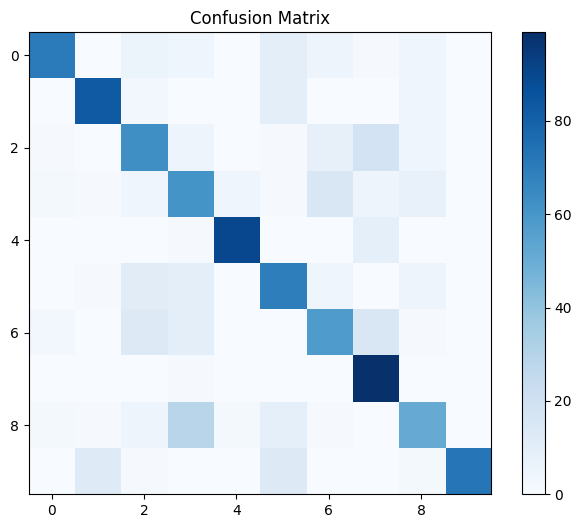

In [15]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.show()

Sample of predictions:
   image_id       predicted_label
0         0               Pasture
1         1         PermanentCrop
2         2  HerbaceousVegetation
3         3               Pasture
4         4         PermanentCrop
5         5                Forest
6         6           Residential
7         7            AnnualCrop
8         8           Residential
9         9               Highway


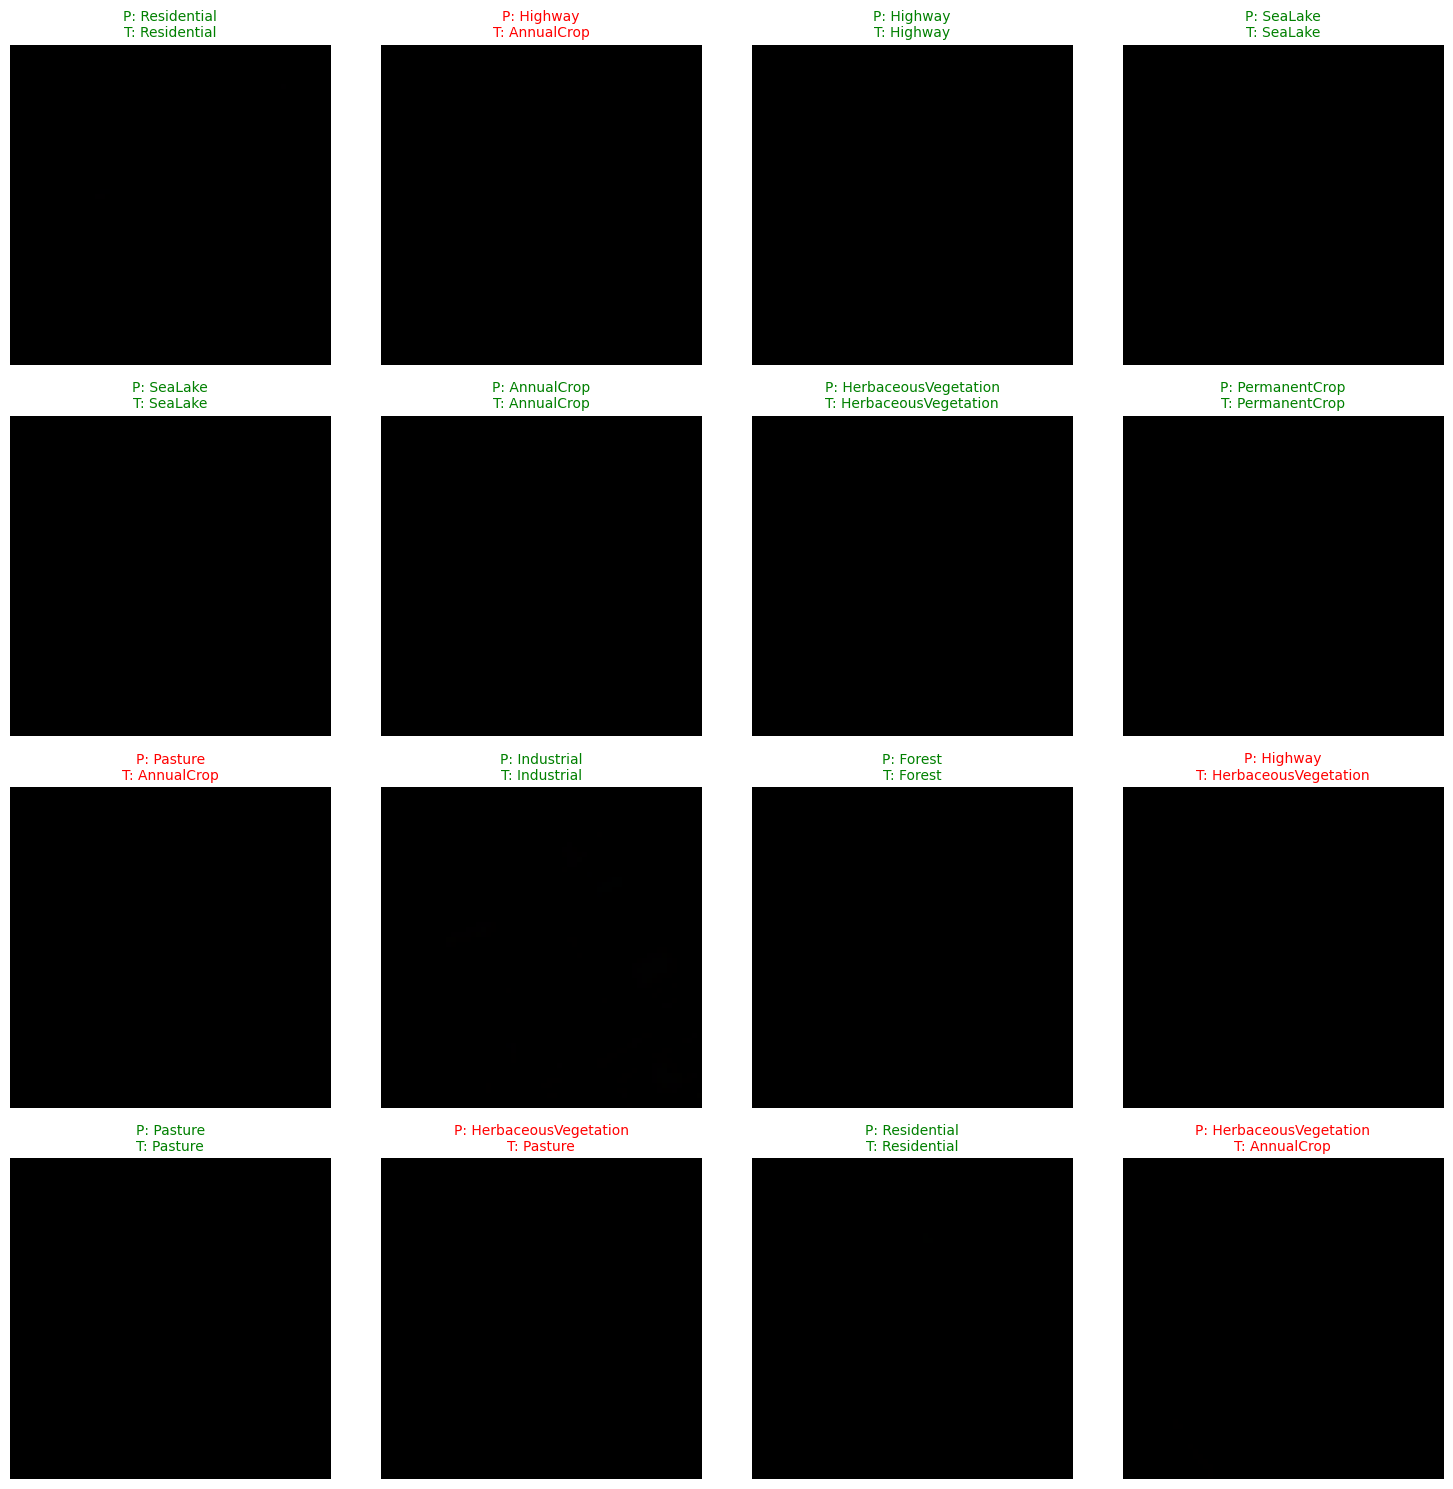

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from PIL import Image

# Load predictions
df_preds = pd.read_csv("/content/predictions.csv")
print("Sample of predictions:")
print(df_preds.head(10))

num_samples = 16
indices = random.sample(range(len(X_test)), num_samples)

plt.figure(figsize=(15, 15))
for i, idx in enumerate(indices):
    # Check if X_test contains file paths (strings)
    if isinstance(X_test[idx], str):
        img = Image.open(X_test[idx])
    else:
        # Assume numpy array
        img_array = X_test[idx]
        img = Image.fromarray(img_array.astype('uint8'))

    pred_label = df_preds.iloc[idx]["predicted_label"]
    true_label = le.inverse_transform([y_test[idx]])[0]

    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.axis("off")

    color = "green" if pred_label == true_label else "red"
    plt.title(f"P: {pred_label}\nT: {true_label}", color=color, fontsize=10)

plt.tight_layout()
plt.show()


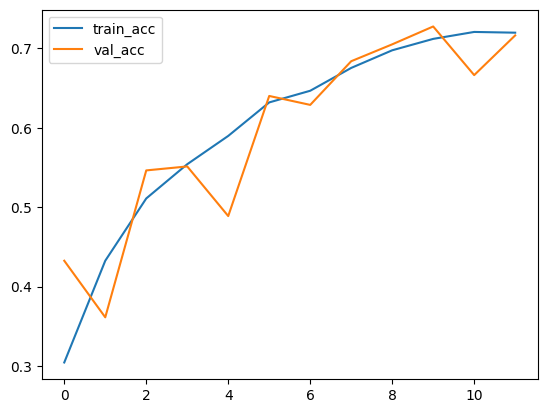

In [22]:
# ===============================
# STEP 8 — TRAINING CURVES
# ===============================
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
